In [1]:
import Pkg; Pkg.activate(".")

  Activating project at `/mnt/chromeos/GoogleDrive/MyDrive/Lab/Optical Instruments/VST/Simulator`


In [2]:
Pkg.instantiate()

In [3]:
using Unitful
using PhysicalConstants.CODATA2018: h, c_0
using PhysicalConstants.CODATA2018	
using UnitfulAstro 
using Distributions
using CairoMakie
using DataFrames
using Interpolations
using CSV

In [4]:
extpath = joinpath("data","Paranal.dat")
extdata = CSV.File(extpath; comment="#",header=["λ", "Ext", "eExt"])
exttbl = DataFrame(extdata)
exttbl.λ .= exttbl.λ.*u"angstrom"
extfnt = linear_interpolation(exttbl.λ, exttbl.Ext, extrapolation_bc = NaN);

In [5]:
gpath = joinpath("data","VST_g_eff.txt")
gdata = CSV.File(gpath; comment="#",header=["λ", "Eff"])
gtbl = DataFrame(gdata)
gtbl.λ .= gtbl.λ.*u"nm"
gtbl.Eff = gtbl.Eff / 100
gfnt = linear_interpolation(gtbl.λ, gtbl.Eff, extrapolation_bc = 0.);

In [6]:
rpath = joinpath("data","VST_r_eff.txt")
rdata = CSV.File(rpath; comment="#",header=["λ", "Eff"])
rtbl = DataFrame(rdata)
rtbl.λ .= rtbl.λ.*u"nm"
rtbl.Eff = rtbl.Eff / 100
rfnt = linear_interpolation(rtbl.λ, rtbl.Eff, extrapolation_bc = 0.);

In [7]:
ppath = joinpath("data","Polaroid.csv")
pdata = CSV.File(ppath; comment="#",header=["λ", "Eff"])
ptbl = DataFrame(pdata)
ptbl.λ .= ptbl.λ.*u"nm"
ptbl.Eff = ptbl.Eff / 100
pfnt = linear_interpolation(ptbl.λ, ptbl.Eff, extrapolation_bc = 0.);

- Paranal sky brighness is available in the UBVRI system and we [get](https://www.eso.org/sci/facilities/paranal/astroclimate/Obsconditions/NSB.html) $B = 22.64 \pm 0.18, V = 21.61\pm 0.20$ and $R = 20.87 \pm 0.19$.

- Conversion to grzi filters is described [here](https://classic.sdss.org/dr5/algorithms/sdssUBVRITransform.php).

- We then get: $g = 22.14$ and $r = 21.25$.

In [8]:
NightSky = Dict("g" => 22.14, "r" => 21.25);

In [9]:
struct TelData
    TelescopeRaggioPrimario
    TelescopeRaggioSecondario
    qeffdir
    EffArea    
end

function TelData(TelescopeRaggioPrimario,TelescopeRaggioSecondario,qeffdir)
    EffArea = π*(TelescopeRaggioPrimario^2-TelescopeRaggioSecondario^2)
    return TelData(TelescopeRaggioPrimario,TelescopeRaggioSecondario,qeffdir,EffArea)
end

TelData

In [10]:
tdata = TelData(2.61u"m"/2,0.938u"m"/2,Dict("g" => gfnt, "r" => rfnt));

In [11]:
struct InpData
    ncycles
    filter
    expt
    inpm
    skym
    airm
    inpmag
    skymag
    exptime
    totexptime
    tottelesctime
    inpflux
    skyflux
end

function InpData(ncycles,filter,expt,inpm,skym,airm)
    inpmag = inpm*UnitfulAstro.AB_mag
    skymag = skym*UnitfulAstro.AB_mag
    exptime = expt*u"s"
    totexptime = exptime*ncycles
    perframeoverhead = 39*u"s"
    tottelesctime = ncycles*(exptime + 3*perframeoverhead)
    inpflux = uconvert(u"erg/(s*m^2*Hz)",inpmag)
    skyflux = uconvert(u"erg/(s*m^2*Hz)",skymag);
    return InpData(ncycles,filter,expt,inpm,skym,airm,inpmag,skymag,exptime,totexptime,tottelesctime,inpflux,skyflux)
end

InpData

In [12]:
idata = InpData(1,"g",1800.,16.,NightSky["g"],1.);

In [13]:
struct InpPolData
    SourcePol
    PosAngle
    ModSchema
    ang1
    ang2
    ang3
end

In [56]:
ipdata = InpPolData(0.07,45.,3,0.,60.,120.);

In [57]:
effTime = (1/ipdata.ModSchema)*idata.totexptime;

In [58]:
minλ = 3500.0u"angstrom"
maxλ = 9000.0u"angstrom";

In [59]:
function Computeγ(effarea,efftime,idata::InpData;minλ=3500.0u"angstrom",maxλ=9000.0u"angstrom")
    Numγ = 0.
    Numγsky = 0.
    EffNumγ = 0.
    EffNumγsky = 0.
    for λ in range(start=minλ,stop=maxλ,step=1u"angstrom")
    	bwidth = c_0*u"angstrom"/uconvert(u"m",λ)^2
    	γ = uconvert(u"Hz",bwidth)*effarea*efftime*idata.inpflux/(uconvert(u"erg*s",h)*c_0/uconvert(u"m",λ))
        γsky = uconvert(u"Hz",bwidth)*effarea*efftime*idata.skyflux/(uconvert(u"erg*s",h)*c_0/uconvert(u"m",λ))
    	airmfct = 10^(-0.4*(extfnt(λ)*idata.airm))
    	Numγ = Numγ + γ
    	EffNumγ = EffNumγ + γ*tdata.qeffdir[idata.filter](λ)*airmfct*pfnt(λ)
    	Numγsky = Numγsky + γsky
    	EffNumγsky = EffNumγsky + γsky*tdata.qeffdir[idata.filter](λ)*airmfct*pfnt(λ)
    end    
    return EffNumγ, Numγ, EffNumγsky, Numγsky
end

Computeγ (generic function with 1 method)

In [60]:
EffNumγ, Numγ, EffNumγsky, Numγsky = Computeγ(tdata.EffArea,effTime,idata);

In [61]:
function ComputeQU(effγ,effγsky,inpP,inpΘ;ang1=0.,ang2=60.,ang3=120.,Nsims=10000)
    Q = inpP * cosd(2*inpΘ) * EffNumγ
    U = inpP * sind(2*inpΘ) * EffNumγ
    #
    ModMat = 0.5*[1 cosd(2*ang1) -sind(2*ang1); 1 cosd(2*ang2) -sind(2*ang2); 1 cosd(2*ang3) -sind(2*ang3)]
    inpStk = transpose([EffNumγ Q U])
    skyStk = transpose([EffNumγsky 0. 0.])
    #
    Is = ModMat * inpStk
    Issky = ModMat * skyStk
    #
    dI0 = rand(Poisson(Is[1]),Nsims)+rand(Poisson(Issky[1]),Nsims)-rand(Poisson(Issky[1]),Nsims)
    dI60 = rand(Poisson(Is[2]),Nsims)+rand(Poisson(Issky[2]),Nsims)-rand(Poisson(Issky[2]),Nsims)
    dI120 = rand(Poisson(Is[3]),Nsims)+rand(Poisson(Issky[3]),Nsims)-rand(Poisson(Issky[3]),Nsims)
    dIs = transpose([dI0 dI60 dI120])
    DemodMat = inv(ModMat)
    dStokes = DemodMat * dIs
    sQN = dStokes[2,:] ./ dStokes[1,:] 
    sUN = dStokes[3,:] ./ dStokes[1,:]
    return sQN, sUN
end

ComputeQU (generic function with 1 method)

In [62]:
sQN,sUN =  ComputeQU(EffNumγ,EffNumγsky,ipdata.SourcePol,ipdata.PosAngle);

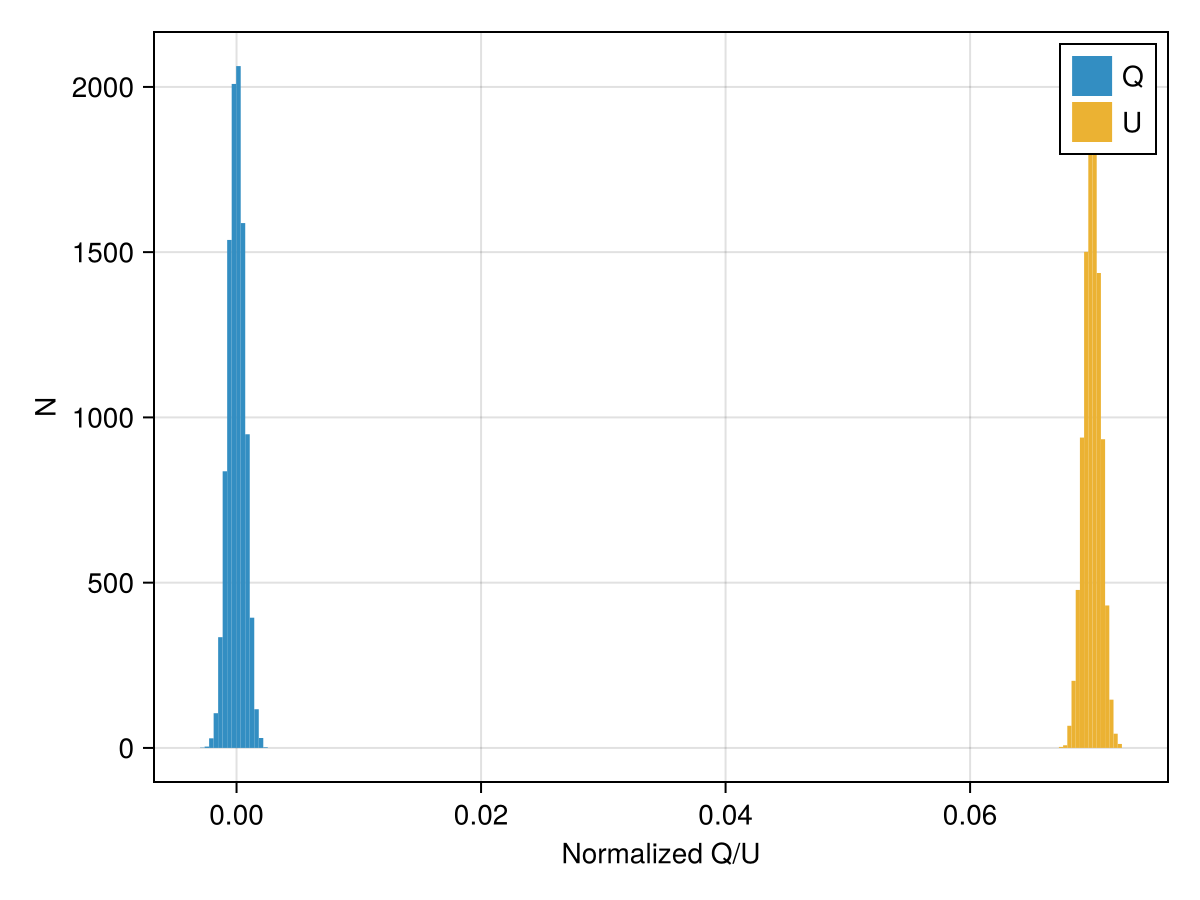

In [63]:
fg1 = Figure()
	
ax1fg1 = Axis(fg1[1, 1],
	xlabel = "Normalized Q/U",
	ylabel = "N"
	)
	
hist!(sQN,label="Q")
hist!(sUN,label="U")
	
axislegend(ax1fg1)
	
fg1

In [64]:
struct PolData
    sP
    sΘ
    P
    σP
    Q
    σQ
    U
    σU
    Θ
    σΘ
    SN
end

In [65]:
function ComputePolData(sQ,sU)::PolData
    Q = mean(sQ)
    σQ = std(sQ)
    U = mean(sU)
    σU = std(sU)
    sP = sqrt.(sQ.^2 .+ sU.^2)
    P = 0.
    σP = 0.
    #
    try
        Pray = fit(Rician,sP)
        σP = params(Pray)[2]
        P = params(Pray)[1]
    catch y
        if isa(y, DomainError)
            PrayR = fit(Rayleigh,sP .- mean(sP))
            σP = params(PrayR)[1]
            P = mean(sP)
        end
    end
    #
    SN = P/σP
    sΘ = 0.5*atand.(sU,sQ)
    Θ = mean(sΘ)
    σΘ = std(sΘ)
    return PolData(sP,sΘ,P,σP,Q,σQ,U,σU,Θ,σΘ,SN)
end

ComputePolData (generic function with 1 method)

In [66]:
pdata = ComputePolData(sQN,sUN);

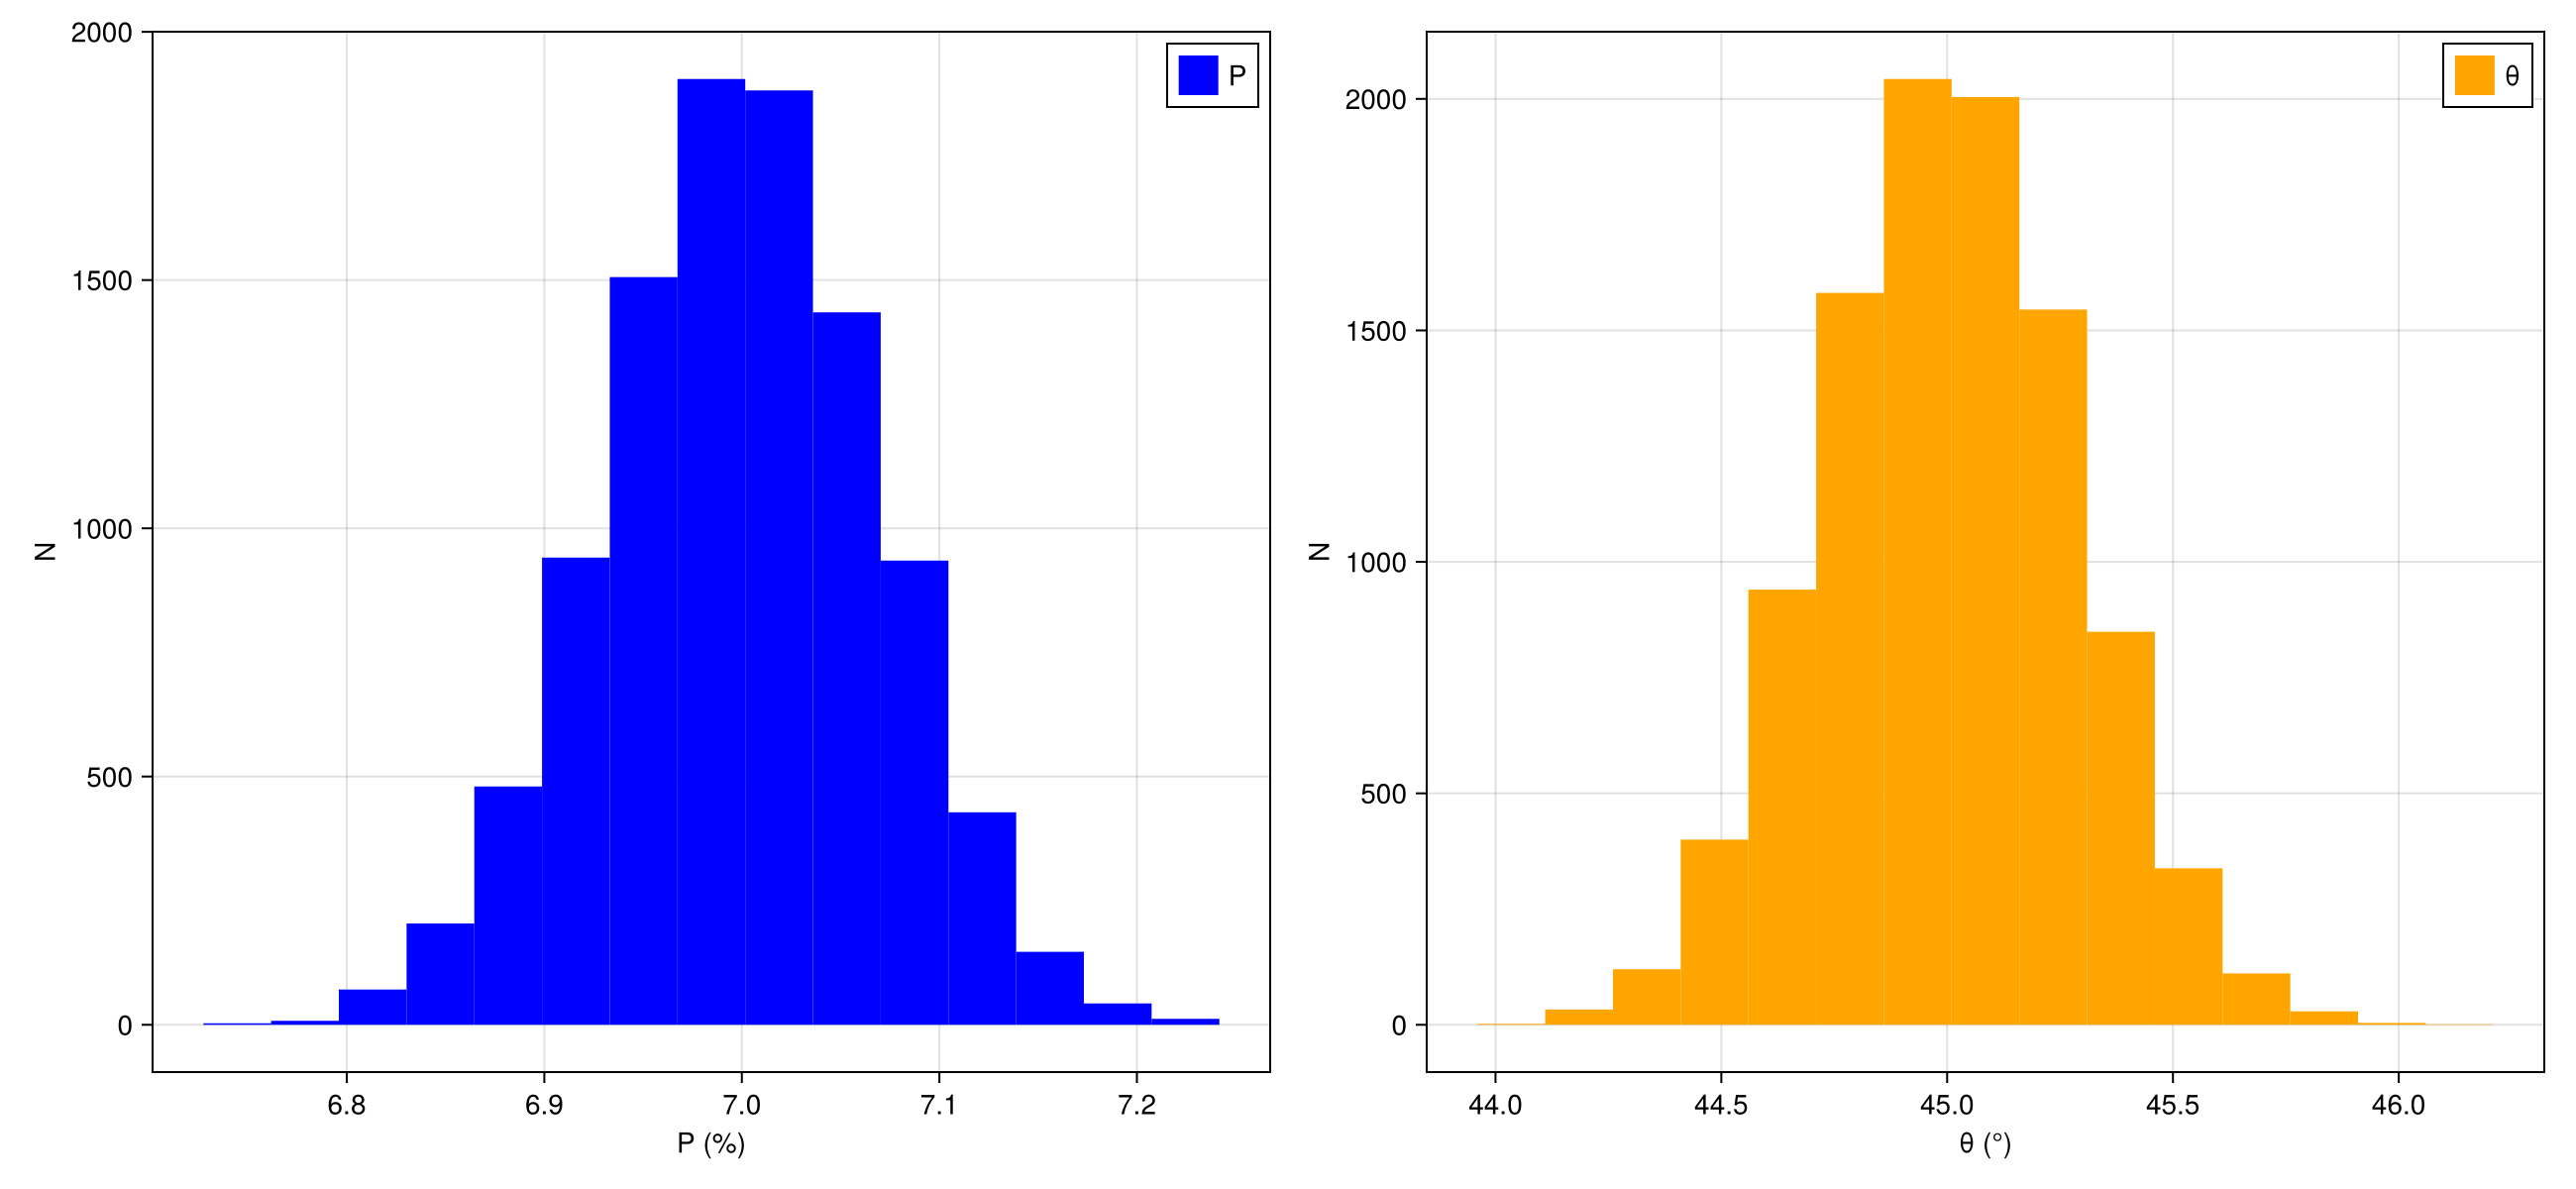

In [67]:
fg2 = Figure(size=(1300,600))
	
ax1fg2 = Axis(fg2[1, 1],
	xlabel = "P (%)",
	ylabel = "N"
	)
	
hist!(100*pdata.sP,label="P",color=:blue)
	
axislegend(ax1fg2)

ax2fg2 = Axis(fg2[1, 2],
	xlabel = "θ (°)",
	ylabel = "N"
	)
	
hist!(pdata.sΘ,label="θ",color=:orange)
	
axislegend(ax2fg2)
	
fg2

In [48]:
magrange = 12:0.1:22.1
exprange = [600.,1200,2400.,3600]
tres = Dict()
ipdata = InpPolData(0.0,0.,3,0.,60.,120.)
for e in exprange
    epres = []
    for m in magrange
        idata = InpData(1,"g",e,m,NightSky["g"],1.)
        effTime = (1/ipdata.ModSchema)*idata.totexptime
        EffNumγ, Numγ, EffNumγsky, Numγsky = Computeγ(tdata.EffArea,effTime,idata)
        sQN,sUN =  ComputeQU(EffNumγ,EffNumγsky,ipdata.SourcePol,ipdata.PosAngle)
        pdata = ComputePolData(sQN,sUN)
        push!(epres,pdata.σQ)
    end
    tres[e]=epres
end

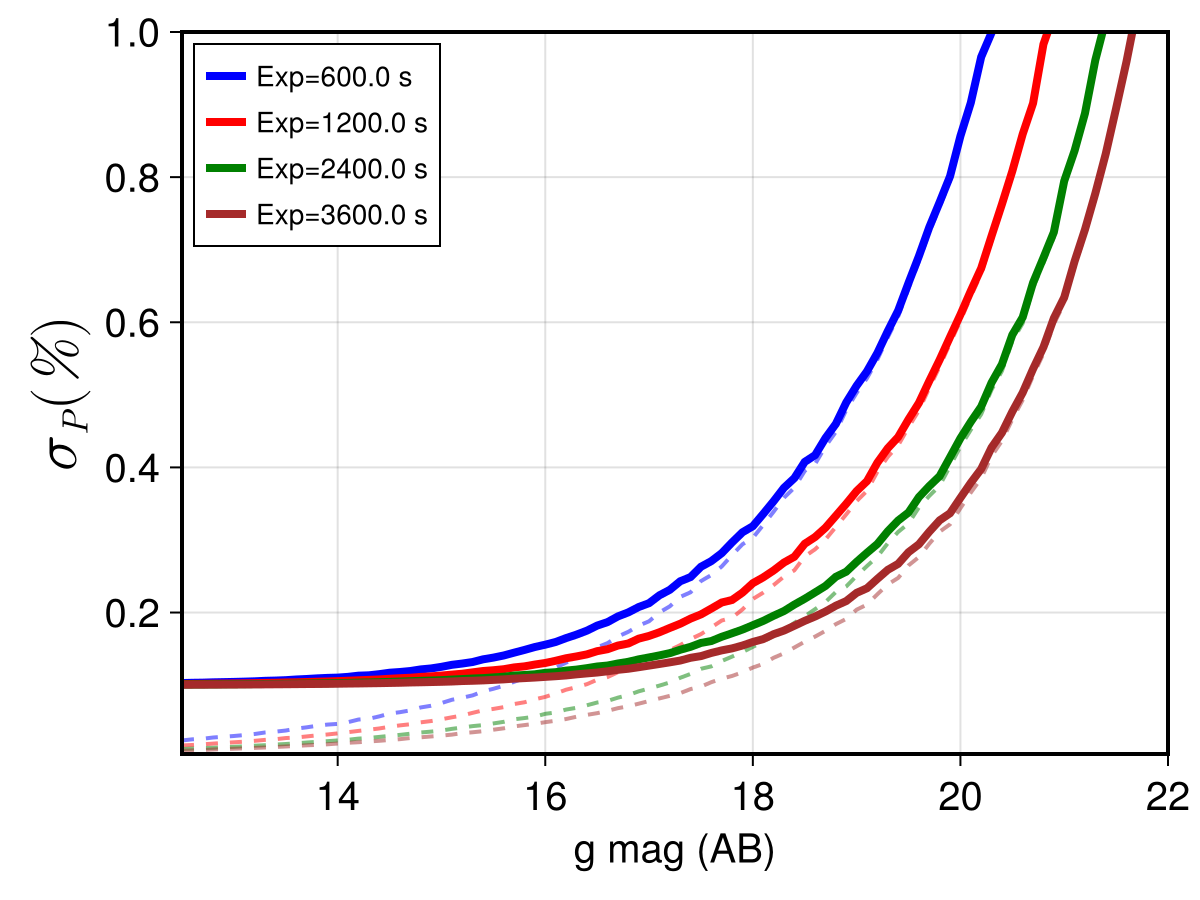

In [49]:
fg3 = Figure()

colors = [:blue,:red,:green,:brown]
styles = [:solid,:dash,:dashdot,:dot]

ax1fg3 = Axis(fg3[1, 1],
    spinewidth=2,
	xlabel = "g mag (AB)",
	ylabel = L"σ_P (%)",
    xlabelsize=20,
    ylabelsize=30,
    titlesize=30,
    xticklabelsize = 20,
    yticklabelsize = 20,
    #yscale=log10
	)

#for (e,c,s) in zip(exprange,colors,styles)
#    lines!(magrange,100 .* tres[e],linewidth=2,color=c,linestyle=s,alpha=0.3)
#    lines!(magrange,100 .* sqrt.(tres[e].^2 .+ 1e-3^2),linewidth=4,color=c,linestyle=s,label="Exp=$e s",)
#end


for (e,c) in zip(exprange,colors)
    lines!(magrange,100 .* tres[e],linewidth=2,color=c,linestyle=:dash,alpha=0.5)
    lines!(magrange,100 .* sqrt.(tres[e].^2 .+ 1e-3^2),linewidth=4,color=c,linestyle=:solid,label="Exp=$e s",)
end


ylims!(5e-3,1)
xlims!(12.5,22)

axislegend(position=:lt)

fg3

In [33]:
save("VSTPOL_plot.pdf", fg3)

CairoMakie.Screen{PDF}
